In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pt

from statsmodels.tsa.ar_model import AR
from statsmodels.api import OLS
from statsmodels.tools.tools import add_constant

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

from datetime import date, datetime, timedelta
import sys

def perdelta(start, end, delta):
    curr = start
    while curr < end:
        yield curr
        curr += delta

# Generating non-stationary time series

In [3]:
data = pd.DataFrame(perdelta(date(2008, 1, 1), date(2018, 1, 31), timedelta(days = 1)), columns = ['date'])
data['time_index'] = data.index

data["yearmonth"] = data["date"].apply(lambda d: d.month)
data["monthday"] = data["date"].apply(lambda d: d.day)
data["weekday"] = data["date"].apply(lambda d: int(d.strftime("%w")))

data = data.set_index('date')

# Train/test split = 90%
split_index = int(0.9*len(data.index)) 

### Autoregression model AR 1

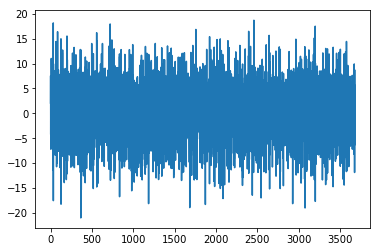

In [4]:
Init_value = 0
c0 = 0
c1 = -0.5
sigma = 5

y_clean = [Init_value]
for i in range(len(data.index)):
    y_clean.append(c0 + c1*y_clean[-1] + sigma*np.random.randn(1)[0])

data['y_clean'] = y_clean[1:]
    
pt.plot(data['time_index'], data['y_clean'])
pt.show()

### Non-linear deterministic trend

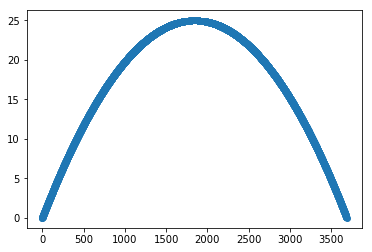

In [5]:
trend_scale = (c0/(1-c1) + 5*sigma)

def trend_shape(t):
    return trend_scale*(1 - 4*(t/len(data.index) - 0.5)**2)

data['trend'] = data['time_index'].apply(lambda t: trend_shape(t))

pt.scatter(data['time_index'], data['trend'])
pt.show()

### Monthly and daily multiplicative seasonality

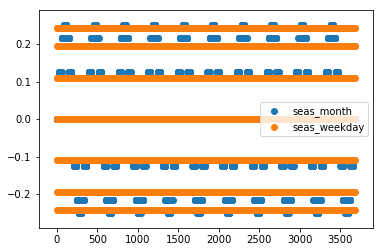

In [6]:
data["seas_yearmonth"] = 0.25 * np.sin((2*np.pi / 12) * (data['yearmonth']-1))
data["seas_weekday"] = 0.25 * np.sin((2*np.pi / 7) * data['weekday'])

pt.scatter(data['time_index'], data['seas_yearmonth'], label='seas_month')
pt.scatter(data['time_index'], data['seas_weekday'], label='seas_weekday')
pt.legend()
pt.show()

### Resulting time series

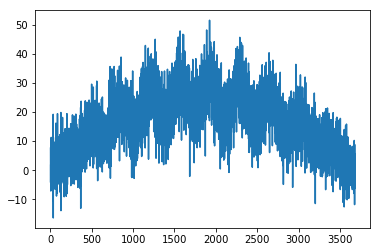

In [7]:
data["y"] = data['trend'] * (1 + data['seas_yearmonth'] + data['seas_weekday']) + data["y_clean"]
data["dy"] = data["y"] - data["y"].shift(1)
data.dropna(inplace=True)

pt.plot(data['time_index'], data['y'])
pt.show()

# Econometric approach: testing various specifications of linear model

### AR 1 model

In [8]:
data_train = data.iloc[:split_index]
data_test = data.iloc[split_index:]

In [9]:
estm = AR(data_train["y"]).fit(maxlag = 1)

const = estm.params['const']
coef = estm.params['L1.y']
print ("intercept: ", const, ", coef: ", coef)

y_pred = const + coef * data_test["y"].shift(1)[1:]
y_true = data_test["y"][1:]
score = mean_squared_error(y_pred = y_pred, y_true = y_true)
print ('MSE on the test dataset is %0.3f.' % score)

intercept:  10.0721929098 , coef:  0.440054706382
MSE on the test dataset is 106.937.


### AR 1 model with differencing

In [10]:
estm = AR(data_train["dy"]).fit(maxlag = 1)

const = estm.params['const']
coef = estm.params['L1.dy']
print ("intercept: ", const, ", coef: ", coef)

y_pred = const + coef * data_test["dy"].shift(1)[1:]
y_true = data_test["dy"][1:]
score = mean_squared_error(y_pred = y_pred, y_true = y_true)
print ('MSE on the test dataset is %0.3f.' % score)

intercept:  0.00208642068856 , coef:  -0.655804880999
MSE on the test dataset is 48.988.


### AR 1 model with differencing and seasonality

In [11]:
Dummies = pd.get_dummies(100*data["yearmonth"]+data["weekday"]).add_prefix('seas_').iloc[:,1:]

Dummies_train = Dummies.iloc[:split_index]
Dummies_test = Dummies.iloc[split_index:]

In [12]:
exog = add_constant(pd.DataFrame(data_train["dy"].shift(1)).join(Dummies_train))
endog = data_train["dy"]
estm = OLS(endog = endog, exog = exog, missing = 'drop', hasconst = True).fit()

print ("intercept: ", estm.params['const'], ", coef: ", estm.params['dy'])

y_pred = estm.predict(add_constant(pd.DataFrame(data_test["dy"].shift(1)).join(Dummies_test)))[1:]
y_true = data_test["dy"][1:]
score = mean_squared_error(y_pred = y_pred, y_true = y_true)
print ('MSE on the test dataset is %0.3f.' % score)

intercept:  4.08836002085 , coef:  -0.747122128897
MSE on the test dataset is 54.861.


### AR 1 model with monthly MA trend and additive seasonality

In [13]:
MA_len = 30
data['y_MA'] = data['y'].rolling(window=MA_len).mean()

data_train = data.iloc[MA_len-1 : split_index]
data_test = data.iloc[split_index : ]

Dummies_train = Dummies.iloc[MA_len-1 : split_index]
Dummies_test = Dummies.iloc[split_index : ]

In [14]:
exog = add_constant(pd.DataFrame(data_train[["y","y_MA"]].shift(1)).join(Dummies_train))
endog = data_train["y"]
estm = OLS(endog = endog, exog = exog, missing = 'drop', hasconst = True).fit()

print ("intercept: ", estm.params['const'], ", coef: ", estm.params['y'])

y_pred = estm.predict(add_constant(pd.DataFrame(data_test[["y","y_MA"]].shift(1)).join(Dummies_test)))[1:]
y_true = data_test["y"][1:]
score = mean_squared_error(y_pred = y_pred, y_true = y_true)
print ('MSE on the test dataset is %0.3f.' % score)

intercept:  1.26538128306 , coef:  -0.465648251695
MSE on the test dataset is 33.855.


### AR 1 model with monthly MA trend and multiplicative seasonality - TRUE SPECIFICATION

intercept:  0.855303633309 , coef:  -0.511397422931


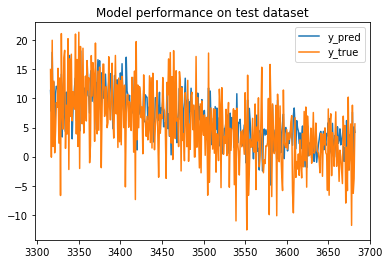

MSE on the test dataset is 25.650.


In [15]:
exog = add_constant(data_train[["y","y_MA"]].shift(1).join(Dummies_train.mul(data_train["y_MA"].shift(1), axis=0)))
endog = data_train["y"]
estm = OLS(endog = endog, exog = exog, missing = 'drop', hasconst = True).fit()

print ("intercept: ", estm.params['const'], ", coef: ", estm.params['y'])

y_pred = estm.predict(add_constant(
        data_test[["y","y_MA"]].shift(1).join(Dummies_test.mul(data_test["y_MA"].shift(1), axis=0))))[1:]
y_true = data_test["y"][1:]

pt.title('Model performance on test dataset')
pt.plot(data_test['time_index'][1:], y_pred, label='y_pred')
pt.plot(data_test['time_index'][1:], y_true, label='y_true')
pt.legend()
pt.show()

score = mean_squared_error(y_pred = y_pred, y_true = y_true)
print ('MSE on the test dataset is %0.3f.' % score)

# Machine learning approach: fitting non-linear models with cross-validation

In [16]:
CV_splits = 50

### Step 1. Kernel regression for trend

Grid MSE scores on development set:
-61.406 (+/-34.733) for {'gamma': 1.1e-07}
-61.404 (+/-34.702) for {'gamma': 1.125e-07}
-61.404 (+/-34.678) for {'gamma': 1.15e-07}
-61.406 (+/-34.661) for {'gamma': 1.175e-07}
-61.409 (+/-34.651) for {'gamma': 1.2e-07}

Best MSE score is -61.404. Best parameters set found on development set:
{'gamma': 1.15e-07}


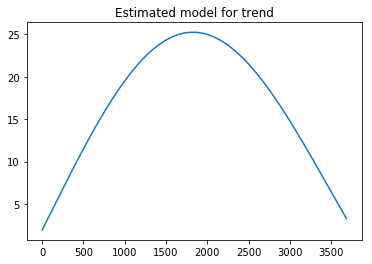

In [21]:
data_train = data.iloc[:split_index]
data_test = data.iloc[split_index:]

estm_s1 = KernelRidge(kernel = 'rbf')
tuned_parameters = [{'gamma': [1.1e-7, 1.125e-7, 1.15e-7, 1.175e-7, 1.2e-7]}]


grid = GridSearchCV(estimator=estm_s1, param_grid=tuned_parameters,
                   cv=TimeSeriesSplit(n_splits=CV_splits), scoring="neg_mean_squared_error")
grid.fit(data_train['time_index'].values.reshape(-1, 1), data_train['y'].values)

print("Grid MSE scores on development set:")
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
        % (mean, 2 * std, params))
print()
print("Best MSE score is %0.3f." % grid.best_score_, "Best parameters set found on development set:")
print(grid.best_params_)

estm_s1.set_params(**grid.best_params_)
estm_s1.fit(data_train['time_index'].values.reshape(-1, 1), data_train["y"].values)


pt.title('Estimated model for trend')
pt.plot(data['time_index'], estm_s1.predict(data['time_index'].values.reshape(-1, 1)))
pt.show()

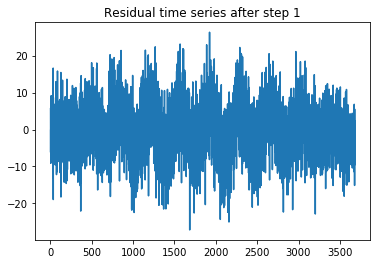

In [22]:
data['trend_est'] = estm_s1.predict(data['time_index'].values.reshape(-1, 1))
data['y_res1'] = data['y'] - data['trend_est']

pt.title('Residual time series after step 1')
pt.plot(data['time_index'], data['y_res1'])
pt.show()

### Step 2. Gradient boosting regression for seasonality

Grid MSE scores on development set:
-39.720 (+/-18.858) for {'max_leaf_nodes': None, 'n_estimators': 21}
-39.902 (+/-19.591) for {'max_leaf_nodes': None, 'n_estimators': 22}
-39.592 (+/-19.158) for {'max_leaf_nodes': None, 'n_estimators': 23}
-39.730 (+/-20.100) for {'max_leaf_nodes': None, 'n_estimators': 24}
-39.670 (+/-20.039) for {'max_leaf_nodes': None, 'n_estimators': 25}
-40.289 (+/-24.481) for {'max_leaf_nodes': 7, 'n_estimators': 21}
-40.192 (+/-24.545) for {'max_leaf_nodes': 7, 'n_estimators': 22}
-40.109 (+/-24.521) for {'max_leaf_nodes': 7, 'n_estimators': 23}
-40.154 (+/-24.564) for {'max_leaf_nodes': 7, 'n_estimators': 24}
-40.231 (+/-25.745) for {'max_leaf_nodes': 7, 'n_estimators': 25}
-40.125 (+/-21.140) for {'max_leaf_nodes': 10, 'n_estimators': 21}
-39.960 (+/-21.146) for {'max_leaf_nodes': 10, 'n_estimators': 22}
-40.218 (+/-22.094) for {'max_leaf_nodes': 10, 'n_estimators': 23}
-40.096 (+/-22.154) for {'max_leaf_nodes': 10, 'n_estimators': 24}
-40.082 (+/-22.343) f

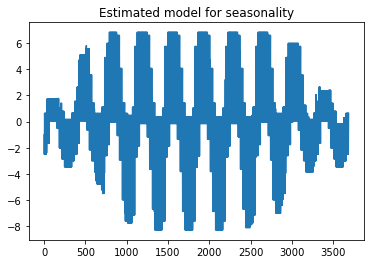

In [57]:
# Restrict number of trees to prevent overfitting

param = ['trend_est', 'yearmonth', 'monthday', 'weekday']

data_train = data.iloc[:split_index]
data_test = data.iloc[split_index:]

estm_s2 = GradientBoostingRegressor(learning_rate = 0.1, max_features = 'auto', max_depth = len(param) - 1)
tuned_parameters = [{'n_estimators': [21, 22, 23, 24, 25], 'max_leaf_nodes': [None, 7, 10, 12]}]


grid = GridSearchCV(estimator=estm_s2, param_grid=tuned_parameters,
                   cv=TimeSeriesSplit(n_splits=CV_splits), scoring="neg_mean_squared_error")
grid.fit(data_train[param], data_train['y_res1'])

print("Grid MSE scores on development set:")
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
        % (mean, 2 * std, params))
print()
print("Best MSE score is %0.3f." % grid.best_score_, "Best parameters set found on development set:")
print(grid.best_params_)

estm_s2.set_params(**grid.best_params_)
estm_s2.fit(data_train[param], data_train['y_res1'])


pt.title('Estimated model for seasonality')
pt.plot(data['time_index'], estm_s2.predict(data[param]))
pt.show()

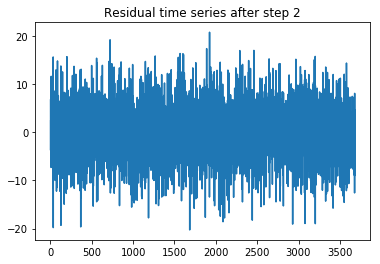

In [58]:
data['seas_est'] = estm_s2.predict(data[param])
data['y_res2'] = data['y_res1'] - data['seas_est']

pt.title('Residual time series after step 2')
pt.plot(data['time_index'], data['y_res2'])
pt.show()

### Step 3. ARMA model for residual stationary fluctuations

In [59]:
data_train = data.iloc[:split_index]
data_test = data.iloc[split_index:]

estm_s3 = AR(data_train["y_res2"]).fit(maxlag = 1)

const = estm_s3.params['const']
coef = estm_s3.params['L1.y_res2']
print ("intercept: ", const, ", coef: ", coef)

intercept:  -0.00294662416356 , coef:  -0.450377944537


### Step 4. Combining all machine learning models together

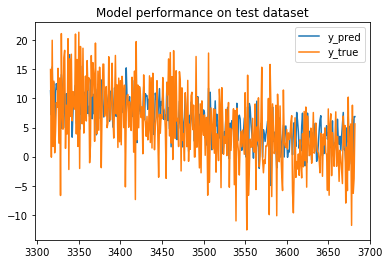

MSE on the test dataset is 25.377.


In [60]:
y_res2_pred = const + coef * data_test["y_res2"].shift(1)[1:]
y_res1_pred = y_res2_pred + estm_s2.predict(data_test[param])[1:]
y_pred = y_res1_pred + estm_s1.predict(data_test['time_index'].values.reshape(-1, 1))[1:]
y_true = data_test["y"][1:]

pt.title('Model performance on test dataset')
pt.plot(data_test['time_index'][1:], y_pred, label='y_pred')
pt.plot(data_test['time_index'][1:], y_true, label='y_true')
pt.legend()
pt.show()

score = mean_squared_error(y_pred = y_pred, y_true = y_true)
print ('MSE on the test dataset is %0.3f.' % score)